In [1]:
example_date = '2015-12-03'
gtfs_path = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/gtfs/'
code_filepath = '..'
# contains interpolations for 2015-12-01 thru 2015-12-07
interps = '/gpfs2/projects/project-bus_capstone_2016/workspace/share/dec2015_interpolated.csv' 

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  

# these modules are homemade
os.chdir(code_filepath)
import gtfs
import ttools

### Load schedule data for a single weekday

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips(example_date,gtfs_path)
#stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times(example_date,gtfs_path)
tcal=gtfs.TransitCalendar(example_date,gtfs_path)
active_services = tcal.get_service_ids(example_date)
active_trips = trips.service_id.isin(active_services)
active_stops = stop_times.reset_index().set_index('trip_id').loc[active_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [3]:
active_stops['sched_hour'] = active_stops.arrival_time.str[:2].astype(int)
active_stops['sched_arrival_time'] = active_stops.arrival_time.apply(ttools.parseTime)

In [4]:
sched_times = active_stops.join(trips['route_id'],how='left')
sched_times = sched_times.reset_index().sort(['route_id','sched_arrival_time'])

#### Calculate headway between each scheduled arrival

In [5]:
sec = ttools.datetime.timedelta(seconds=1)
sched_times['sched_headway'] = sched_times.groupby(['route_id','stop_id'])['sched_arrival_time'].diff()/sec

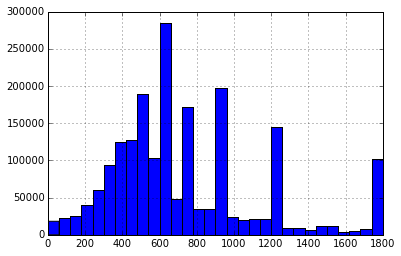

In [6]:
sched_times['sched_headway'].hist(range=(0,1800),bins=30)

In [7]:
sched_times.set_index(['trip_id','stop_id'],inplace=True,verify_integrity=True)

### Load estimated stop times based on Bus Time data (four consecutive weekdays)

In [8]:
interpolated = pd.read_csv(interps) 
interpolated = interpolated[interpolated['trip_date']<='2015-12-04']
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])

### Join schedule information on the reported TRIP_ID

In [11]:
merged = interpolated.merge(sched_times[['sched_arrival_time','sched_hour','sched_headway']],how='left',left_on=['TRIP_ID','STOP_ID'],right_index=True)

In [12]:
# beware - processing time for sorting increases exponentially!  this data sample takes 3-5 minutes.
merged.set_index(['ROUTE_ID','trip_date','STOP_ID'],inplace=True)
merged = merged.set_index('interpolated_arrival_time',append=True,drop=False).sort_index()

TRIP_ID  vehicle_id  \
ROUTE_ID trip_date  STOP_ID                                                    
BX4      2015-12-01 100204   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100206   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100207   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100209   GH_D5-Weekday-SDon-072200_BX44A_115        1232   
                    100211   GH_D5-Weekday-SDon-072200_BX44A_115        1232   

                             interpolated_arrival_time  sched_arrival_time  \
ROUTE_ID trip_date  STOP_ID                                                  
BX4      2015-12-01 100204             12:17:12.252435            12:03:27   
                    100206             12:18:47.609879            12:04:58   
                    100207             12:20:41.306924            12:06:26   
                    100209             12:23:33.335432            12:08:00   
                    100211             12:25:13.534420            12:10:13   

                             sched_hour  sched_headway  
ROUTE_ID trip_date  STOP_ID                             
BX4      2015-12-01 100204           12           1200  
                    100206           12           1200  
                    100207           12           1200  
                    100209           12           1200  
                    100211           12           1217

### Calculate headway between each estimated arrival

In [15]:
sec = ttools.datetime.timedelta(seconds=1)
merged['inter_headway'] = merged.groupby(level=(0,1,2))['interpolated_arrival_time'].diff()/sec
merged.head(25)

TRIP_ID  \
ROUTE_ID trip_date  STOP_ID interpolated_arrival_time                                    
B1       2015-12-01 300000  05:04:59.663721             UP_D5-Weekday-SDon-030500_B1_5   
                            05:30:42.700777             UP_D5-Weekday-SDon-033000_B1_7   
                            10:09:01.078491            UP_D5-Weekday-SDon-060800_B1_13   
                            12:37:29.048152            UP_D5-Weekday-SDon-075100_B1_17   
                            12:53:32.616912            UP_D5-Weekday-SDon-076300_B1_11   
                            13:36:15                    UP_D5-Weekday-SDon-081100_B1_9   
                            13:49:00.077493            UP_D5-Weekday-SDon-082300_B1_32   
                            14:00:27.062338            UP_D5-Weekday-SDon-083500_B1_34   
                            14:07:47.069384            UP_D5-Weekday-SDon-084200_B1_36   
                            15:10:24.079422            UP_D5-Weekday-SDon-090900_B1_39   
                            22:14:54                   UP_D5-Weekday-SDon-133000_B1_40   
                    300002  01:00:57.302967             UP_D5-Weekday-SDon-006000_B1_1   
                            02:20:44.756889             UP_D5-Weekday-SDon-014000_B1_1   
                            03:03:45.487774             UP_D5-Weekday-SDon-018000_B1_2   
                            03:40:05.728617             UP_D5-Weekday-SDon-022000_B1_1   
                            05:04:24.933491             UP_D5-Weekday-SDon-030500_B1_5   
                            05:30:18.073091             UP_D5-Weekday-SDon-033000_B1_7   
                            05:45:00.495628             UP_D5-Weekday-SDon-034500_B1_3   
                            06:02:11.119749             UP_D5-Weekday-SDon-036000_B1_2   
                            06:27:14.564137             UP_D5-Weekday-SDon-038600_B1_4   
                            06:35:29.907428             UP_D5-Weekday-SDon-039600_B1_9   
                            06:46:03.693952             UP_D5-Weekday-SDon-040600_B1_5   
                            07:06:02.962673            UP_D5-Weekday-SDon-042300_B1_15   
                            07:23:08.922512            UP_D5-Weekday-SDon-043100_B1_16   
                            07:52:57.040049            UP_D5-Weekday-SDon-046800_B1_11   

                                                       vehicle_id  \
ROUTE_ID trip_date  STOP_ID interpolated_arrival_time               
B1       2015-12-01 300000  05:04:59.663721                  4859   
                            05:30:42.700777                  7169   
                            10:09:01.078491                  7159   
                            12:37:29.048152                  4890   
                            12:53:32.616912                  4880   
                            13:36:15                         7144   
                            13:49:00.077493                  7186   
                            14:00:27.062338                  7162   
                            14:07:47.069384                  7183   
                            15:10:24.079422                  5112   
                            22:14:54                         7178   
                    300002  01:00:57.302967                  4871   
                            02:20:44.756889                  4871   
                            03:03:45.487774                  4882   
                            03:40:05.728617                  4871   
                            05:04:24.933491                  4859   
                            05:30:18.073091                  7169   
                            05:45:00.495628                  5095   
                            06:02:11.119749                  4882   
                            06:27:14.564137                  7185   
                            06:35:29.907428                  5083   
                            06:46:03.693952                  

## Define labeling and measurement functions

In [16]:
# Peak Hour is between 07:00 and 08:59, or 16:00 and 18:59
def peak_hour_int(x):
    if x >= 7 and x < 9:
        return True
    elif x >= 16 and x < 19:
        return True
    else:
        return False
merged['P_hour'] = map(lambda x:peak_hour_int(x),merged['sched_hour'])

### Wait Assessment

In [17]:
# Wait Assessment is a True/False condition on the difference between schedule and actual headway, depending on whether it's during Peak Hour
def wait_ass(x,y):
    if x == True:
        if y >= 3*60:
            return False
        else:
            return True
    if x == False:
        if y>= 5*60:
            return False
        else:
            return True         
merged['hw_diff'] = merged['inter_headway']-merged['sched_headway']
merged['wait_ass'] = map(lambda x,y:wait_ass(x,y), merged['P_hour'],merged['hw_diff'])

## For each route, return the STOP_ID with the most number of estimated arrival times

In [18]:
def series_max(s):
    return s.idxmax()[1]
trip_groups = merged.groupby(level=(0,2)).size()
densest_stops = trip_groups.groupby(level=(0)).apply(series_max)
densest_stops

ROUTE_ID
B1      300011
B100    350130
B103    307840
B11     301182
B12     301329
B13     504094
B14     301598
B15     301049
B16     301625
B17     301788
B2      300168
B20     301963
B24     302349
B25     302383
B26     302464
B3      300262
B31     302610
B32     801164
B35     302759
B36     307205
B37     302914
B38     303039
B39     403679
B4      300026
B41     303242
B42     303358
B43     303765
B44     303385
B44+    303488
B45     303535
         ...  
X10     404208
X10B    405017
X11     203200
X12     200534
X14     903205
X15     401797
X17     403311
X17A    404202
X17J    200401
X19     202090
X2      203344
X21     202239
X22     202089
X22A    250058
X27     404225
X28     404231
X3      201052
X30     201571
X31     201476
X37     300073
X38     402130
X4      200097
X42     401832
X5      402851
X63     402212
X64     500332
X68     500074
X7      905090
X8      200104
X9      203344
dtype: int64

In [19]:
# collect the WA measurements for each route based on its "most dense" stop (i.e. the stop with the most number of estimated arrivals)
wa_df = pd.DataFrame(columns=['wa'])
for route, stop in densest_stops.iteritems():
    wa_df.loc[route] = merged.loc[(route,example_date,stop)]['wait_ass'].mean()
# check average of all routes collected
wa_df.mean()

wa    0.786535
dtype: float64

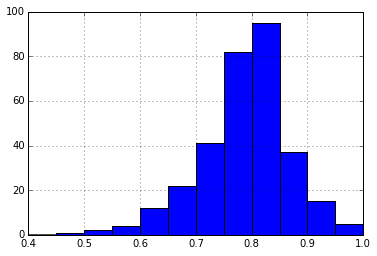

In [20]:
# Show disribution of route performance
wa_df.wa.hist(range=(0.4,1.0),bins=12)

## Best and worst routes (based on off-peak measurement at densest stop)

In [21]:
wa_offpeak_df = pd.DataFrame(columns=['wa_offpeak'])
for route, stop in densest_stops.iteritems():
    stopslice = merged.loc[(route,example_date,stop)]
    wa_offpeak_df.loc[route] = stopslice[stopslice['P_hour']==False]['wait_ass'].mean()
wa_offpeak_df.mean()

wa_offpeak    0.819212
dtype: float64

In [22]:
print (wa_offpeak_df.sort('wa_offpeak',ascending=False)[:20])
print (wa_offpeak_df.sort('wa_offpeak',ascending=True)[:20])

      wa_offpeak
X9             1
X14            1
Q103           1
Q15A           1
QM16           1
QM24           1
QM7            1
S84            1
S90            1
S92            1
S94            1
S98            1
B32            1
X10B           1
QM18           1
X64            1
X4             1
X22            1
X3             1
X30            1
      wa_offpeak
S81     0.000000
X15     0.333333
QM5     0.451613
X63     0.500000
X22A    0.500000
BM5     0.500000
QM8     0.500000
X11     0.500000
BX20    0.500000
QM20    0.571429
M35     0.586957
M50     0.589744
B39     0.600000
X2      0.600000
M98     0.600000
S96     0.600000
BX34    0.600000
BM3     0.615385
BM2     0.615385
M57     0.632653
